In [1]:
import re
import pandas as pd
import numpy as np
import altair as alt
import requests
import pandas as pd
import altair as alt
from bs4 import BeautifulSoup
import sklearn.pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
%matplotlib inline
%load_ext pycodestyle_magic
#%%pycodestyle
#%%flake8

In [22]:
def scrape_suspicions(season):  # returns a DataFrame with suspicions of a certain season
    # https://pythonprogramminglanguage.com/web-scraping-with-pandas-and-beautifulsoup/
    res = requests.get("http://wiewasdemol.nl/seizoen-"+str(season)+"/verdenkingen")
    soup = BeautifulSoup(res.content, 'lxml')
    table = soup.find_all('table')[0]
    df = pd.read_html(str(table))[0]
    return df


def scrape_poi(season):  # returns interesting information about a season
    res = requests.get("http://wiewasdemol.nl/seizoen-" + str(season))
    # soup = BeautifulSoup(res.content, 'lxml')
    soup = BeautifulSoup((res.content))
    # print (soupp.prettify())
    mol = re.search('>(.*)<', str(soup.find_all('a')[-4]))[1]
    winner = re.search('>(.*)<', str(soup.find_all('a')[-3]))[1]
    loser = re.search('>(.*)<', str(soup.find_all('a')[-2]))[1]
    result = {'mol': mol, 'winner': winner, 'loser': loser}
    if season == 7:
        result = {'mol': 'Inge', 'winner': 'Paul', 'loser': 'Eva'}
    viewers = re.search('\((.*) kijkers\)', str(soup))[1]
    result['viewers'] = int(viewers.replace(".", ""))
    result['earnings'] = int(re.search('<dt>Opbrengst</dt>\n<dd>. (.*)</dd>', str(soup))[1])
    result['potential_earnings'] = int(re.search('<dt>Beschikbaar</dt>\n<dd>. (.*)</dd>', str(soup))[1])
    result['percentage_earned'] = result['earnings']/result['potential_earnings']
    if season == 1 or season == 2:
        result['earnings'] = result['earnings'] / 2.2
        result['potential_earnings'] = result['potential_earnings']/2.2
    return result


def show_progress(input, scale, x_title, y_title):  # helper function to plot a multiline chart
    if not isinstance(input, pd.DataFrame):
        chart_data = pd.DataFrame(input)
    else:
        chart_data = input
    chart_data.index.name = "x"
    chart_data = chart_data.reset_index().melt('x')
    result = alt.Chart(
        chart_data, width=600,
        height=240).mark_line().encode(
        alt.X('x', scale=alt.Scale(domain=scale), axis=alt.Axis(domain=True)),
        y='value',
        color='variable'
    )  # .properties(title='Percent of work-force working as Welders')
    result.encoding.x.title = x_title
    result.encoding.y.title = y_title
    result.display()


def histogram(data):  # helper function to plot a histogram
    source = pd.DataFrame({'max_votes': data})
    result = alt.Chart(source).mark_bar().encode(
        alt.X("max_votes", bin=True),
        y='count()',
    )
    result.display()


def count_on_poi(suspicion, poi):  # returns the votes a poi got, accounting for fractional votes
    count_correct = 0
    for target in suspicion.dropna():
        if poi in target:
            num_guesses = len(target.split())
            count_correct += 1/num_guesses
    return count_correct


def count_full_on_poi(suspicion, poi):  # returns the votes a poi got, only counting full votes
    count_correct = 0
    for target in suspicion.dropna():
        if poi == target:
            count_correct += 1
    return count_correct


def vote_correct(vote, mol):  # returns a 1 if guessed correctly, 0 if incorrectly, fraction if the vote was split or none if vote was unknown
    # print (mol, vote)
    if pd.isnull(vote) or vote == '?':
        return
    elif mol in vote:
            num_guesses = len(vote.split())
            return 1/num_guesses
    else:
        return 0


def votes_by_chance_mol(votes):  # given the number of participants and the votes known, return the expected amount of times the mol would have been guessed
    expected_votes = 0
    for i, row in votes.iterrows():
        expected_votes += (1 / row[0]) * (row[1])
    return (expected_votes)


def votes_by_chance(votes):  # given the number of participants and the votes known, return the expected amount of times the mol would have been guessed
    expected_votes = 0
    for i, row in votes.iterrows():
        if not pd.isnull(row[1]):
            expected_votes += (1 / row[0]) * (row[2] - row[1])
    return (expected_votes)


def how_strange_is_that(votes):  # returns the odds that given a vote pattern, the participant got the correct votes by chance
    correct = 0
    odds = []
    for i, row in votes.iterrows():
        if not pd.isnull(row[1]):
            correct += row[1]
            odds.append(1 - 1 / row[0])
    odds = np.array(odds)
    odds = odds.reshape(odds.shape[0], 1)
    x = np.random.rand(odds.shape[0], 100000)
    y = np.less(odds, x)
    z = np.sum(y, axis=0)
    return len(z[z >= correct]) / 100000


def count_maximum_votes(votes):  # returns the maximum amount of votes on the same participant
    counts = votes.value_counts()
    if '?' in counts.index:
        # split vote
        counts = counts.drop('?')
    return counts.max()


def make_suspicions(season):  # returns a augmented suspicions DataFrame, including computed features
    poi_info = scrape_poi(season)
    suspicions = scrape_suspicions(season)
   
    temp = suspicions[['Aflevering', poi_info['mol']]].copy()
    suspicions.drop('Aflevering', axis=1, inplace=True)
    suspicions.drop(poi_info['mol'], axis=1, inplace=True)

    initial_columns = suspicions.columns
    suspicions['num_participants'] = suspicions.count(axis=1)
    suspicions['unknown_votes'] = suspicions.isin(['?']).sum(axis=1)
    suspicions['votes_known'] = suspicions['num_participants']-suspicions['unknown_votes']
    suspicions['winner_known'] = suspicions[poi_info['winner']] != '?'
    suspicions['loser_known'] = suspicions[poi_info['loser']] != '?'
    suspicions['winner_known'] = suspicions['winner_known'].astype(int)
    suspicions['loser_known'] = suspicions['loser_known'].astype(int)
    suspicions['mol_expected_votes'] = (1/suspicions['num_participants']) * suspicions['votes_known']
    suspicions['winner_expected_votes'] = (1/suspicions['num_participants']) * (suspicions['votes_known']-suspicions['winner_known'])
    suspicions['loser_expected_votes'] = (1/suspicions['num_participants']) * (suspicions['votes_known']-suspicions['loser_known'])
    suspicions['mol_actual_votes'] = [count_on_poi(row, poi_info['mol']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['winner_actual_votes'] = [count_on_poi(row, poi_info['winner']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['loser_actual_votes'] = [count_on_poi(row, poi_info['loser']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['mol_actual_full_votes'] = [count_full_on_poi(row, poi_info['mol']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['winner_actual_full_votes'] = [count_full_on_poi(row, poi_info['winner']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['loser_actual_full_votes'] = [count_full_on_poi(row, poi_info['loser']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['suspicion_mol'] = suspicions['mol_actual_votes']-suspicions['mol_expected_votes']
    suspicions['suspicion_winner'] = suspicions['winner_actual_votes']-suspicions['winner_expected_votes']
    suspicions['suspicion_loser'] = suspicions['loser_actual_votes']-suspicions['loser_expected_votes']
    suspicions['outmolling_index'] = suspicions['suspicion_winner']-suspicions['suspicion_mol']
    suspicions['winner_scores'] = [vote_correct(i, poi_info['mol']) for i in suspicions[poi_info['winner']]]
    suspicions['loser_scores'] = [vote_correct(i, poi_info['mol']) for i in suspicions[poi_info['loser']]]
    suspicions['season'] = season
    suspicions = pd.concat([temp, suspicions], axis=1)
    # suspicions.drop(initial_columns,axis=1,inplace=True)
  
    initial_columns = initial_columns.append(pd.Index({poi_info['mol']}))
    suspicions['num_participants_incl_mol'] = suspicions['num_participants']+1
    suspicions['unknown_votes_incl_mol'] = suspicions.isin(['?']).sum(axis=1)
    suspicions['votes_known_incl_mol'] = suspicions['num_participants_incl_mol']-suspicions['unknown_votes_incl_mol']
    suspicions['winner_expected_votes_incl_mol'] = (1/suspicions['num_participants']) * (suspicions['votes_known_incl_mol']-suspicions['winner_known'])
    suspicions['loser_expected_votes_incl_mol'] = (1/suspicions['num_participants']) * (suspicions['votes_known_incl_mol']-suspicions['loser_known'])
    suspicions['winner_actual_votes_incl_mol'] = [count_on_poi(row, poi_info['winner']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['loser_actual_votes_incl_mol'] = [count_on_poi(row, poi_info['loser']) for i, row in suspicions[initial_columns].iterrows()]
    suspicions['suspicion_winner_incl_mol'] = suspicions['winner_actual_votes_incl_mol']-suspicions['winner_expected_votes_incl_mol']
    suspicions['suspicion_loser_incl_mol'] = suspicions['loser_actual_votes_incl_mol']-suspicions['loser_expected_votes_incl_mol']

    return (suspicions, initial_columns.tolist(), poi_info)

In [3]:
# get all the seasons. This could have been done better with a single dictionary
result = pd.DataFrame({})
mollist = []
participants = []
winnerlist = []
loserlist = []
viewerlist = []
earningslist = []
potential_earningslist = []
percentage_earnedlist = []

for season in range(1, 19):  # currently 18 seasons
    print('importing season', season)
    seasondata = make_suspicions(season)
    result = pd.concat([result, seasondata[0]], sort=False)
    participants += seasondata[1]
    mollist.append(seasondata[2]['mol'])
    winnerlist.append(seasondata[2]['winner'])
    loserlist.append(seasondata[2]['loser'])
    viewerlist.append(seasondata[2]['viewers'])
    earningslist.append(seasondata[2]['earnings'])
    potential_earningslist.append(seasondata[2]['potential_earnings'])
    percentage_earnedlist.append(seasondata[2]['percentage_earned'])
print(len(mollist), ' seasons imported!')
writer = pd.ExcelWriter('WieIsDeMol.xlsx')
result.to_excel(writer, 'Sheet1')
writer.save()
print('data saved to excel!')

importing season 1
importing season 2
importing season 3
importing season 4
importing season 5
importing season 6
importing season 7
importing season 8
importing season 9
importing season 10
importing season 11
importing season 12
importing season 13
importing season 14
importing season 15
importing season 16
importing season 17
importing season 18
18  seasons imported!
data saved to excel!


# Wie is de Mol: Ontmaskerd

Wie is de Mol is enorm populair in Nederland. We zijn inmiddels toe aan het 19e seizoen. Dat betekent dat we langzamerhand ook behoorlijk wat data tot onze beschikking krijgen en er data analyse op kunnen loslaten. Het blijkt een hele leuke dataset te zijn en gaandeweg kwamen er veel interessante vragen naar boven. Ik hoop een aantal WidM vragen te beantwoorden en je misschien ook enthousiast te maken voor data science. Als input heb ik informatie van de site <url>http://wiewasdemol.nl/</url> gebruikt, die veel informatie bijhoudt. Leuk om ook eens op te kijken. Dank hiervoor Ronald!

En uiteindelijk behandelijk we ook de hamvraag, kunnen we het voorspellen: Wie Is De Mol?

Veel leesplezier!

- Voor de data-fans, onderaan staat een link naar GitHub om de code in een Jupyter Notebook te downloaden.
- Voor de niet data-fans, je kan ook meteen naar beneden scrollen voor de eindconclusies

## Korte uitleg

Voor als je WidM niet kent: het spel start met ongeveer 10 deelnemers. Een van hen is de mol. De deelnemers krijgen opdrachten om geld te verdienen, maar weten dus niet wie de mol is. De mol probeert ervoor te zorgen dat het team weinig geld verdient met de opdrachten.

Elke aflevering is er een stemronde, waarin deelnemers vragen over de mol krijgen. Degene met de meeste fouten moet het spel verlaten. De mol blijft altijd in het spel. Uiteindelijk blijven er nog 3 deelnemers over: de mol en twee deelnemers. De deelnemers krijgen weer vragen over de mol. Degene met het meeste goed is de winnaar. De andere noemen we de verliezer, maar deze is wel ver gekomen! De winnaar verdient de pot.

## Kijkcijfers

Even een opwarmertje, en voor KRO/NCRV belangrijk: hoe populair is het programma? In onderstaande grafiek zie je de kijkcijfers van de meest populaire aflevering, per seizoen. Begon het programma nog met 1 miljoen kijkers, inmiddels zitten we aan meer dan 3 miljoen. Dit lijkt momenteel ook het maximum te zijn.

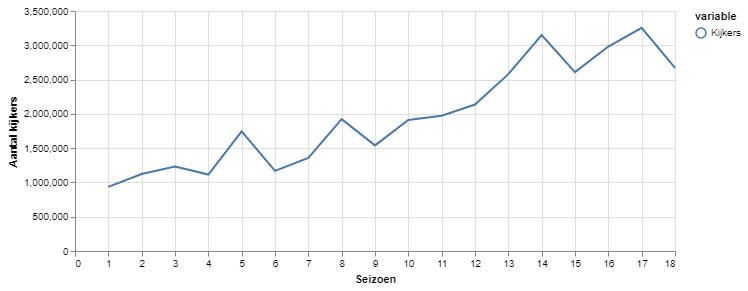

In [23]:
temp = pd.DataFrame({'Kijkers': viewerlist})
temp.index = temp.index + 1
show_progress(temp, [1, 18], 'Seizoen', 'Aantal kijkers')

## Welke informatie is beschikbaar?

Elke aflevering krijgen we sommige verdenkingen van deelnemers te zien. Als er heel weinig verdenkingen tijdens de aflevering worden gedeeld kunnen we waarschijnlijk niet hele betrouwbare conclusies trekken. We maken een grafiek waarin we berekenen hoeveel procent van de verdenkingen bekend is. 1 betekent dat we alle verdenkingen van alle deelnemers weten. De verdenkingen van de mol nemen we nu nog niet mee, die heeft natuurlijk hele andere motieven om iemand te 'verdenken'.

Het lijkt erop dat we als tv kijker iets minder te zien krijgen. Lag tot en met seizoen 9 het percentage nog rond de 80%, tegenwoordig moeten we het met 60% doen. Seizoen 5 en 12 zijn sowieso gekke uitschieters. Dit betekent dat we over deze seizoenen waarschijnlijk niet veel kunnen zeggen. 

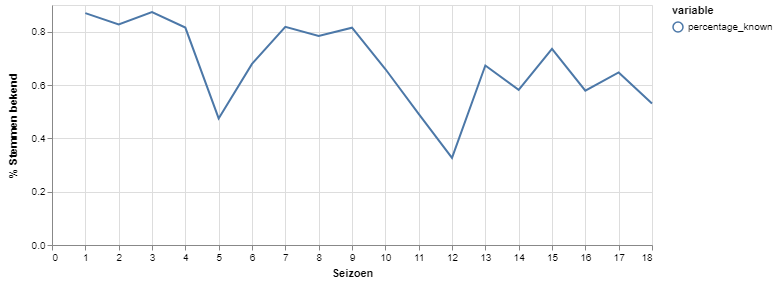

In [24]:
temp = result[['unknown_votes', 'num_participants']].groupby(result['season']).sum()
temp['percentage_known'] = (temp['num_participants'] - temp['unknown_votes']) / temp['num_participants']
show_progress(temp['percentage_known'], [1, 18], 'Seizoen', '% Stemmen bekend')

## Hoe verdacht is de mol?

Als deelnemers geen idee hebben wie de mol is zullen ze gokken. Door dit gokgedrag verwachten we dat elk seizoen de mol toevallig een aantal verdenkingen door gokkers op zich krijgt. Het aantal 'gokverdenkingen' verschilt per seizoen omdat het verschilt hoeveel verdenkingen de tv makers ons laten zien (de grafiek hierboven).

In onderstaande grafiek zie je per seizoen hoeveel 'stemmen' de mol heeft gekregen, en hoeveel we hadden verwacht op basis van gokken. Als de gele lijn boven de blauwe lijn komt is de mol verdacht en andersom.

Nico uit seizoen 2 en Margriet uit seizoen 15 zijn behoorlijk verdacht. Maar de meest verdachte mol is toch wel Jon, uit seizoen 9. Zowel Anniek, Dennis als Vivienne hadden hem al vrij snel in de smiezen. 

Tegelijkertijd zijn er ook een paar niet verdachte mollen in een seizoen waar er wel veel geld uit de pot is gehaald: seizoen 6 (Milouska), 8 (Dennis) en 17 (Thomas).

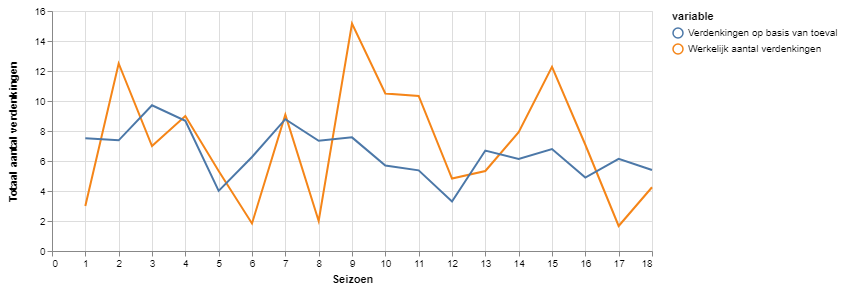

In [25]:
# calculate how often the mol would have been guessed correctly if just guessing
temp = result[['mol_actual_votes', 'mol_expected_votes']].groupby(result['season']).sum()
temp.rename({'mol_actual_votes': 'Werkelijk aantal verdenkingen', 'mol_expected_votes': 'Verdenkingen op basis van toeval'}, axis='columns', inplace=True)
show_progress(temp, [1, 18], 'Seizoen', 'Totaal aantal verdenkingen')

## Zijn winnaars vaak aan het mollen?

Een veelgehoorde trend is dat er steeds meer gemold wordt. We kunnen dit onderzoeken door te kijken hoe verdacht de winnaar en de verliezer zijn. Terzijde: dit kan natuurlijk ook te maken hebben met hoe verdacht de mol was (verdachte mol = niet verdachte winnaar).

Eens kijken naar de winnaar, in hoeverre hij/zij de aandacht op zich wisten te vestigen. Natuurlijk verwacht je altijd wel een paar verdenkingen op je te krijgen, dus het wordt pas verdacht als je hier boven zit. Het beste voorbeeld hiervan zien we in seizoen 14, waarin Sofie veel meer verdenkingen op zich kreeg dan verwacht. Ook afgelopen seizoen 18 was Ruben een verdachte winnaar. 

Toch vind ik het knapper als je kan winnen zonder verdacht te zijn. Bijvoorbeeld seizoen 9 en 12 waarin het heel duidelijk was dat de winnaar een hardwerkende deelnemer was. Complimenten Viviënne en Hadewych!

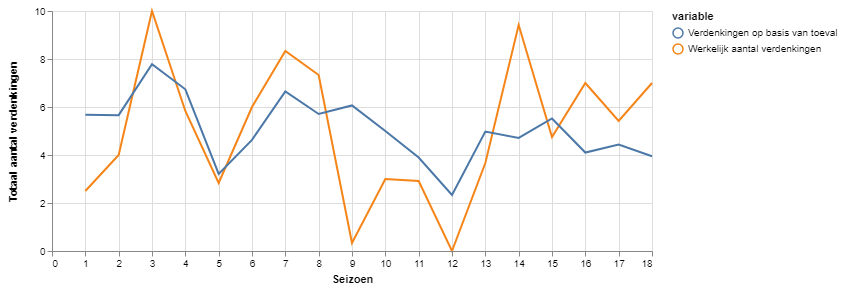

In [26]:
# calculate how often the winner would have been guessed correctly if just guessing
temp = result[['winner_actual_votes', 'winner_expected_votes']].groupby(result['season']).sum()
temp.rename({'winner_actual_votes': 'Werkelijk aantal verdenkingen', 'winner_expected_votes': 'Verdenkingen op basis van toeval'}, axis='columns', inplace=True)
show_progress(temp, [1, 18], 'Seizoen', 'Totaal aantal verdenkingen')

## En verliezers? 

Hetzelfde plaatje voor de verliezers. Zoals je hieronder ziet is de verliezer vaak een stuk minder verdacht dan de winnaar: de blauwe lijntjes liggen vaak boven de gele. Ook afgelopen seizoen was Olcay overduidelijk niet de mol.

Uitzondering die de regel bevestigt is seizoen 4, waarin Chandrika zeer verdacht was, maar het uiteindelijk Elise was die echt de mol was. 

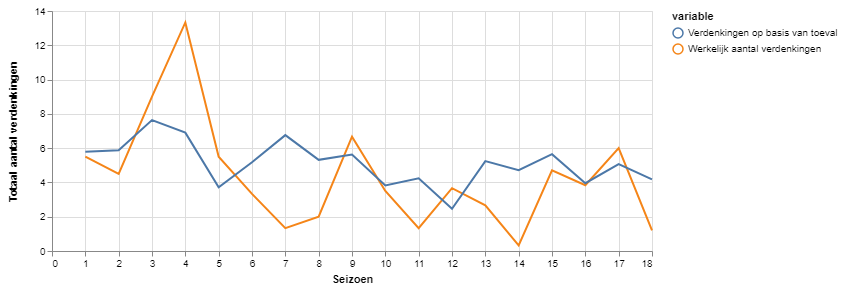

In [27]:
# calculate how often the winner would have been guessed correctly if just guessing
temp = result[['loser_actual_votes','loser_expected_votes']].groupby(result['season']).sum()
temp.rename({'loser_actual_votes':'Werkelijk aantal verdenkingen', 'loser_expected_votes': 'Verdenkingen op basis van toeval'}, axis='columns', inplace=True)
show_progress(temp, [1, 18], 'Seizoen', 'Totaal aantal verdenkingen')


## Kunnen deelnemers de Mol ontmaskeren?

De deelnemers maken elke aflevering een test, waarbij ze vragen over de mol moeten beantwoorden. Soms geven ze ook aan wie ze verdenken. Maar in hoeverre weten de deelnemers wie de mol is, of wordt er maar wat gegokt? Het lijkt logisch dat er op het begin wordt gegokt en dat er uiteindelijk een beter beeld ontstaat wie de mol is. Laten we kijken hoe goed de uiteindelijke winnaar en verliezer weten te voorspellen wie de mol is.

En inderdaad, op het begin van het spel, als er nog veel deelnemers zijn doen de winnaars en verliezers het ongeveer even goed als puur gokken. Dit blijft zo, totdat er nog 4 deelnemers zijn. We zien dat de verliezer het ongeveer even goed blijft doen als gokken, maar de winnaar gaat het veel beter doen. Als er nog 2 deelnemers over zijn (winnaar en verliezer) heeft de winnaar het altijd goed. In de helft van de 18 seizoenen hebben we we hier informatie over. We weten dus niet zeker of het in de andere helft van de seizoenen ook zo was.

Maar toch, 100% score: indrukwekkend!

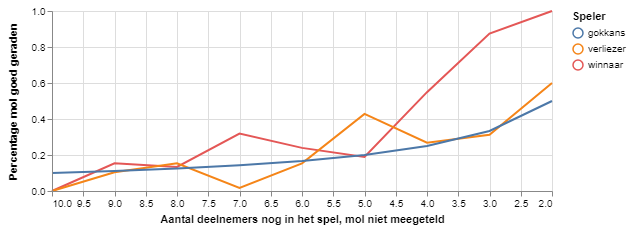

In [28]:
# lets see per stage of the game how often winner and loser have been correct, and compare that to sheer guessing (at end of the game you have a 50% chance of guessing right)
winbyparticipant = result[['winner_scores', 'loser_scores']].groupby(result['num_participants']).mean()
winbyparticipant['gokkans'] = 1 / winbyparticipant.index
chart_data = winbyparticipant
chart_data.index.name = "Aantal deelnemers nog in het spel, mol niet meegeteld"
chart_data.rename({'winner_scores': 'winnaar', 'loser_scores': 'verliezer'}, axis='columns', inplace=True)
chart_data = chart_data.reset_index().melt('Aantal deelnemers nog in het spel, mol niet meegeteld')
chart_data.rename({'value': 'Percentage mol goed geraden', 'variable': 'Speler'}, axis='columns', inplace=True)

chart = alt.Chart(
    chart_data, width=500,
    height=180).mark_line().encode(
    alt.X('Aantal deelnemers nog in het spel, mol niet meegeteld', scale=alt.Scale(domain=[10, 2])),
    y='Percentage mol goed geraden',
    color='Speler'
)
chart.display()

## Wie Is De Mol?

Op basis van bovenstaande grafiek zou je zeggen dat het vrij gemakkelijk is om de mol te ontmaskeren: gewoon luisteren naar de winnaar! Alleen, wie de winnaar is dat weten we pas achteraf. Daarom moeten we nu ook de verdenkingen van de mol meenemen in de verdenkingen. Als je naar alle seizoenen kijkt krijgen zowel de mol en de winnaar iets meer verdenkingen dan verwacht. De verliezer is iets minder verdacht.


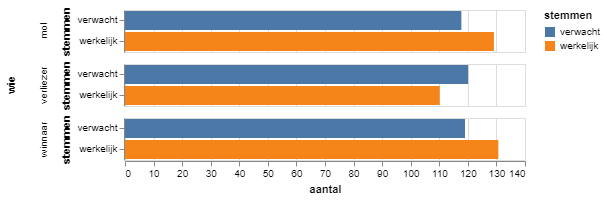

In [29]:
temp = result[['mol_expected_votes', 'mol_actual_votes', 'winner_expected_votes_incl_mol', 'winner_actual_votes_incl_mol', 'loser_expected_votes_incl_mol', 'loser_actual_votes_incl_mol']].sum()
overview = pd.DataFrame({
    'wie': ['mol', 'mol', 'winnaar', 'winnaar', 'verliezer', 'verliezer'],
    'stemmen': ['verwacht', 'werkelijk', 'verwacht', 'werkelijk', 'verwacht', 'werkelijk'],
    'aantal': temp.values})

alt.Chart(overview).mark_bar().encode(
    x='aantal:Q',
    y='stemmen:O',
    color='stemmen:N',
    row='wie:N'
)

Onderstaande grafiek geeft aan hoe verdacht de mol winnaar en verliezer waren. Verdachtheid meten we met het aantal verdenkingen die iemand meer heeft gekregen dan je op basis van toeval zou verwachten. We hebben net ook gezien dat de deelnemers pas bij 4 of minder spelers in het spel meer kans hebben om goed te verdenken dan toeval, dus we kijken alleen naar de verdenkingen in de laatste paar rondes. We zien dat over het algemeen de mol het meest verdacht is. 

De laatste jaren zien we toch meer molgedrag bij de winnaar en is de winnaar meer verdacht dan de verliezer. In 8 van de 18 seizoenen is de mol degene met het meeste stemmen.

Heel duidelijk is dat de verliezer bijna nooit het meest verdacht is, dit is maar 1 keer voorgekomen (seizoen 3).

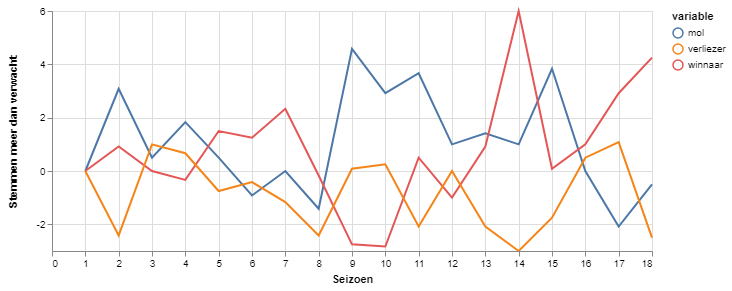

In [30]:
temp = result.loc[result['num_participants'] < 5, :][['suspicion_mol', 'suspicion_winner_incl_mol', 'suspicion_loser_incl_mol', 'season']]  # filter on num participants
temp.reset_index(inplace=True, drop=True)
temp = temp[['suspicion_mol', 'suspicion_winner_incl_mol', 'suspicion_loser_incl_mol']].groupby(temp['season']).sum()
a = temp.copy()
temp.rename({'suspicion_mol': 'mol', 'suspicion_winner_incl_mol': 'winnaar', 'suspicion_loser_incl_mol': 'verliezer'}, axis='columns', inplace=True)
show_progress(temp, [1, 18], 'Seizoen', 'Stemmen meer dan verwacht')

In een uiterste poging heb ik nog geprobeerd om het 'verdenkingsgedrag' van mol en winnaar te vergelijken. 
Ook heb ik gekeken naar:
- Hoevaak iemand een tunnelvisie heeft (dezelfde persoon verdenken). Mollen zijn geneigd om 3 of 4 afleveringen dezelfde persoon te verdenken, een soort fake tunnelvisie.
- Hoe vaak  de verdenkingen van iemand bekend worden gemaakt in de aflevering. Hier kwam geen duidelijk verschil uit tussen mollen en winnaars/verliezers.
- Hoe vaak iemand zijn verdenkingen split. De winnaar deed dat iets vaker dan de mol (9 keer mol vaker, 6 keer winnaar vaker, 3 keer gelijk)
- Of de mol een man of vrouw was. Het enige nuttige hierbij is wanneer er 2 mannen en 1 vrouw in de finale zitten, de mol meestal een man is (6 van de 7 keer is dit voorgekomen)

Door een aantal van deze elementen in een statistisch model op te nemen kon ik onderzoeken of de mol te voorspellen is. Dan kijk je dus naar alle verdenkingen en moet je van 3 deelnemers zeggen wie de mol is, bijvoorbeeld vlak voor de finaleaflevering. Uiteindelijk kon ik in 12 van de 18 seizoenen voorspellen wie de mol was, 2/3 kans dus. Toch al een stuk beter dan 1/3 gokkans, maar zeker niet altijd goed.

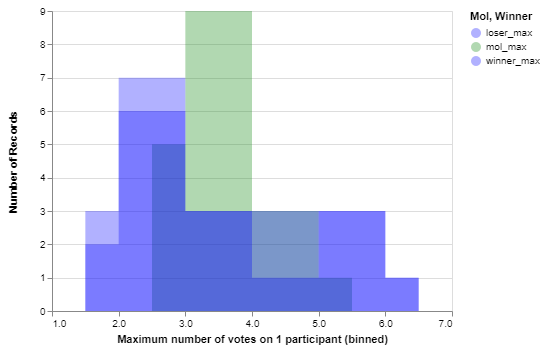

In [31]:
mol_max_votes = [count_maximum_votes(result[i]) for i in mollist]  # max amount of votes cast by mol on single participants
winner_max_votes = [count_maximum_votes(result[i]) for i in winnerlist]
loser_max_votes = [count_maximum_votes(result[i]) for i in loserlist]

source = pd.DataFrame({
    'mol_max': mol_max_votes,
    'winner_max': winner_max_votes,
    'loser_max': loser_max_votes,
})
b = source.copy()
source = pd.melt(
    source,
    id_vars=source.index.name,
    value_vars=source.columns,
    var_name='Mol, Winner',
    value_name='Maximum number of votes on 1 participant'
)

alt.Chart(source).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Maximum number of votes on 1 participant', bin=alt.Bin(maxbins=10)),
    alt.Y('count()', stack=None),
    alt.Color(
        'Mol, Winner',
        scale=alt.Scale(range=['#0000ff', '#008000'])
    )
)

## Money money money

We kunnen ook kijken naar de prijzenpot. In onderstaande grafiek zie je de pot op het einde van het seizoen. De pot lijkt wel steeds kleiner te worden. komt dit doordat er minder geld valt te verdienen, zijn de opdrachten moeilijker of wordt er meer gemold)?

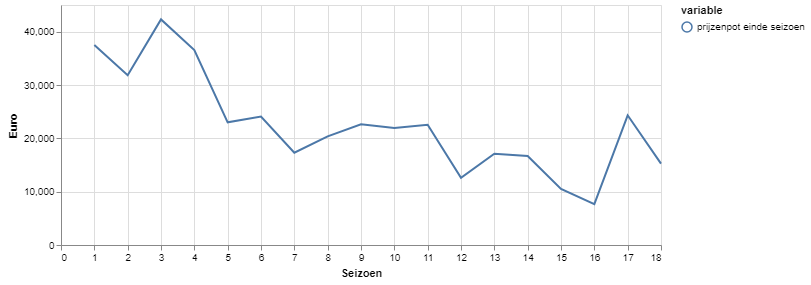

In [32]:
temp = pd.DataFrame({'prijzenpot einde seizoen': earningslist})  # , 'potential_earnings': potential_earningslist
temp.index = np.arange(1, len(temp) + 1)
show_progress(temp, [1, 18], 'Seizoen', 'Euro')

De totale potentiële pot was vooral in de eerste seizoenen erg hoog. In seizoen 3 kon er maar lieft 250.000 euro worden verdiend! Daarna het langzaam af. Bezuinigingen bij de publieke omroep? In seizoen 17 en 18 is er weer wat meer te verdienen.

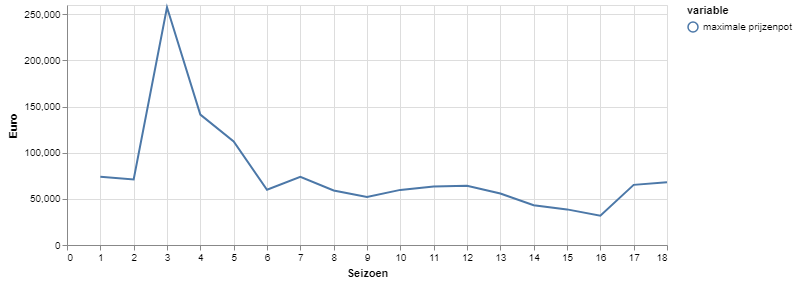

In [33]:
temp = pd.DataFrame({'maximale prijzenpot': potential_earningslist})
temp.index = np.arange(1, len(temp) + 1)
show_progress(temp, [1, 18], 'Seizoen', 'Euro')

Het percentage van de potentiële pot dat wordt binnengehaald schommelt nogal, tussen de 20 en 50 procent. Dit kan natuurlijk door mollen komen, maar soms zijn er ook opdrachten waarbij geld wordt verloren uit de pot. Ik kon geen verband vinden tussen dit percentage en hoe verdacht mol of winnaar was. Misschien komt dit doordat er in sommige seizoenen ook geld kan worden verloren, of misschien is het heel persoonsafhankelijk hoe de mol opereert en hoe goed het team functioneert in geld binnenhalen.

Eigenlijk zijn de winnaar in seizoen 1 (Petra), 2 (Sigrid) en 9 (Hadewych) het meest succesvol geweest. Ze waren ook minder verdacht dan verwacht, dus(?) niet aan het mollen. 

De meest succesvolle mol is wat lastiger maar ik neig naar Anne-Marie uit seizoen 12: niet verdacht, wel een kleine pot. Maar seizoen 3, 4, 5 en 7 waren ook prima! 

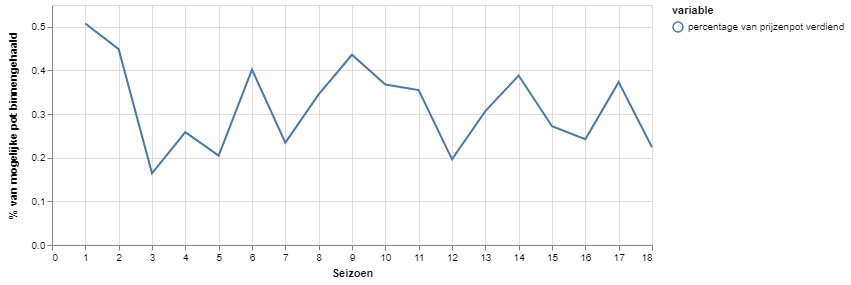

In [34]:
temp = pd.DataFrame({'percentage van prijzenpot verdiend': percentage_earnedlist})
temp.index = np.arange(1, len(temp) + 1)
show_progress(temp, [1, 18], 'Seizoen', '% van mogelijke pot binnengehaald')

## Conclusies

- Er zitten grote verschillen in verdenkingen tussen de seizoenen
- De winnaar weet vrijwel altijd wie de mol is, maar weet het pas de laatste paar afleveringen
- De verliezer weet niet wie de mol en had net zo goed kop of munt kunnen gokken
- De mol wordt eigenlijk alleen door de winnaar ontmaskerd
- De prijzenpot voor WidM is gedaald
- We kunnen geen relatie vinden tussen het percentage van de pot die wordt binnengehaald en het mate van verdenking op mol of winnaar
- We kunnen op basis van de verdenkingen iets beter voorspellen wie de mol is (12 van de 18 seizoenen goed voorspeld)

Voor de toekomst kan het leuk zijn om de verdenkingen van het publiek via de mol-app te bekijken. Doen de tv kijkers het beter of wordt er maar wat gegokt en krijgen we eigenlijk te weinig echte hints?

Welke vragen heb je zelf nog? Veel plezier met Wie is de Mol dit seizoen!

Mocht je data science leuk vinden kan ik je van harte aanraden om eens een gratis online Python programmeercursus te volgen!

In [35]:
var_a = a.stack().sort_index(level=1).reset_index(drop=True)
var_b = b.stack().sort_index(level=1).reset_index(drop=True)
isfemale = [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
c = pd.DataFrame({'isfemale': isfemale}).reset_index(drop=True)
var_c = c.stack().reset_index(drop=True)
features = pd.concat([var_a, var_b, var_c], sort=False, axis=1)
features.rename({0: 'suspicion_index', 1: 'max_vote', 2: 'gender'}, axis='columns', inplace=True)
features = features.values

labels = np.full(54, 1)
labels[0:18] = 0
len(labels)

loo = LeaveOneOut()
loo.get_n_splits(np.zeros(18))

models = []
models.append(('Logistic    ', LogisticRegression(solver='liblinear')))
models.append(('KNeigbors   ', KNeighborsClassifier()))

for name, model in models:
    correct = 0
    for train, test in loo.split(np.zeros(18)):
        train_index = np.array(train)
        test_index = np.array(test)
        features_train, features_test = (list(features[train_index]) + list(features[18 + train_index]) + list(features[36 + train_index])), (list(features[test_index]) + list(features[18+test_index]) + list(features[36 + test_index]))
        labels_train, labels_test = list(labels[train_index]) + list(labels[18 + train_index]) + list(labels[36 + train_index]), list(labels[test_index]) + list(labels[18 + test_index]) + list(labels[36 + test_index])
        steps = [
            (name, model)]
        pipeline = sklearn.pipeline.Pipeline(steps)
        pipeline.fit(features_train, labels_train)
        predictions = pipeline.predict_proba(features_test)[:, 0]
        who_is_mol = np.argsort(predictions, axis=0, order=None)
        print(who_is_mol, (who_is_mol[0] == 2).sum(), predictions)
        correct += (who_is_mol[0] == 2).sum()
    print(correct, 'out of 18 seasons correct, is ', correct/18)

[0 1 2] 0 [0.26443727 0.26443727 0.35079172]
[2 1 0] 1 [0.46681657 0.33867605 0.18973389]
[2 1 0] 1 [0.37599329 0.33620973 0.31763232]
[2 1 0] 1 [0.37470944 0.34813848 0.3059296 ]
[2 0 1] 1 [0.31248706 0.5191871  0.26013773]
[0 2 1] 0 [0.20478    0.48586007 0.32465436]
[2 0 1] 1 [0.27225322 0.41487992 0.20952964]
[2 0 1] 1 [0.22327151 0.27244697 0.17749983]
[1 2 0] 0 [0.60557201 0.23038699 0.28391921]
[1 2 0] 0 [0.41831261 0.2511718  0.26410509]
[2 1 0] 1 [0.57153453 0.40773749 0.18678924]
[1 2 0] 0 [0.3444447  0.25359567 0.2895328 ]
[2 1 0] 1 [0.42716228 0.36294308 0.21031043]
[2 0 1] 1 [0.34583892 0.77826144 0.17069382]
[2 1 0] 1 [0.48677514 0.39763196 0.22990853]
[2 0 1] 1 [0.37203756 0.46407206 0.33300083]
[0 2 1] 0 [0.19554873 0.49307446 0.445894  ]
[2 0 1] 1 [0.28029903 0.72566173 0.13325655]
12 out of 18 seasons correct, is  0.6666666666666666
[2 0 1] 1 [0.4 0.4 0.2]
[2 0 1] 1 [0.6 0.6 0.2]
[2 0 1] 1 [0.2 0.2 0. ]
[1 0 2] 0 [0.4 0.2 0.6]
[0 1 2] 0 [0.2 0.2 0.2]
[2 0 1] 1 [0.4 0.

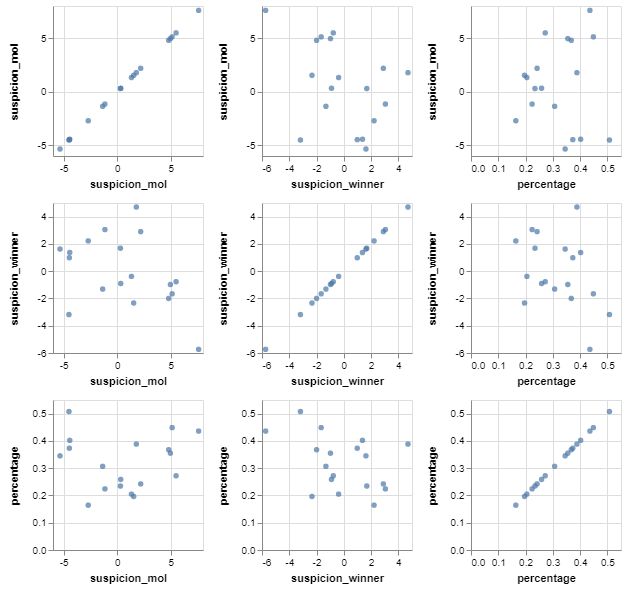

In [17]:
source = result[['suspicion_mol', 'suspicion_winner']].groupby(result['season']).sum()
source['percentage'] = percentage_earnedlist
alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(
    width=150,
    height=150
).repeat(
    row=['suspicion_mol', 'suspicion_winner', 'percentage'],
    column=['suspicion_mol', 'suspicion_winner', 'percentage']
).interactive()